# Import Data

In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib import rcParams
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

# using a query

""" windows authentication
query = ' type your query here '
with pyodbc.connect(r'Driver=SQL Server;Server=______;Database=_____;Trusted_Connection=yes;') as conn:
    with conn.cursor() as cursor:
        df = pd.read_sql(query, conn)
"""

""" with username password
server = _________
user = _________
password = _______
database = _________
query = ' type your query here '
with pymssql.connect(server, user, password, database) as conn:
    with conn.cursor() as cursor:
        df = pd.read_sql(query, conn)
"""

# using a csv file

df1 = pd.read_csv('DailyDelhiClimateTrain.csv')
df2 = pd.read_csv('DailyDelhiClimateTest.csv')
df = pd.concat([df1, df2])


# Clean Data

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\nayakr\AppData\Local\Temp\ipykernel_19896\2947917902.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  myplot.set_xticklabels(myplot.get_xticklabels(), rotation=45);


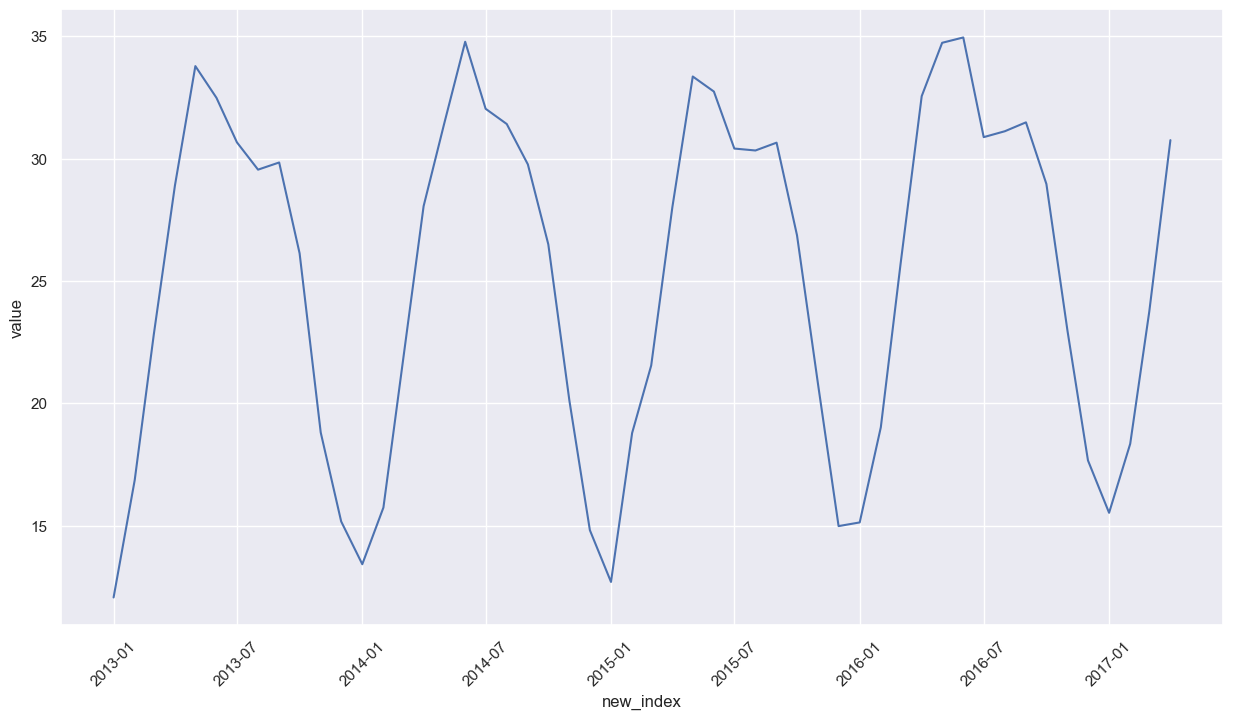

In [2]:
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['new_index'] = df['year'].astype(str) + '-' + df['month'].astype(str) + '-01'
df.new_index = pd.to_datetime(df.new_index)
df.set_index(df.new_index, inplace=True)
df['value'] = df['meantemp']
df.drop(['meantemp', 'date','new_index', 'year', 'month', 'humidity', 'wind_speed', 'meanpressure'], axis=1, inplace=True)
df = df.groupby(df.index).mean()
sns.set()

plt.figure(figsize=(15,8))
myplot= sns.lineplot(x=df.index, y=df['value'].dropna())
myplot.set_xticklabels(myplot.get_xticklabels(), rotation=45);

# Defining methods

In [3]:
# Splitting data for testing and training 80-20 split
def train_test_split(df):
    tss = TimeSeriesSplit(n_splits = 3)
    df.sort_index(inplace=True)
    for train_index, test_index in tss.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
    return train, test

# To check for seasonality
def plot_seasonality(df):
    decomposition = sm.tsa.seasonal_decompose(df['value'].dropna())
    
    # rcParams["figure.figsize"] = 16, 4
    decomposition.plot()
    # decomposition.seasonal.plot();
    # xcoords = ['2020-01-01', '2021-01-01','2022-01-01', '2023-01-01', '2024-01-01']
    # for xc in xcoords:
    #     plt.axvline(x=xc, color='black', linestyle='--')

# Possible d, D and m combinations
def differencing(timeseries, m):
    info = []
    
    # "general" differencing only (d = 0 or 1 or 2)
    for i in range(3):
        timeseries.name = f"d{i}_D0_m0"
        info.append(timeseries)
        timeseries = timeseries.diff()
    
    # seasonal differencing (D = 1) given d = 0 or 1 or 2
    for i in m:
        for j in range(3):
            timeseries = info[j].diff(periods=i)
            timeseries.name = f"d{j}_D1_m{i}"
            info.append(timeseries)
    
    # seasonal differencing (D = 2) given d = 0 or 1 or 2
    for i in m:
        for j in range(3):
            timeseries = info[j+3].diff(periods=i)
            timeseries.name = f"d{j}_D2_m{i}"
            info.append(timeseries)
        
    return pd.DataFrame(info).T

# Test for stationarity
def adf_summary(diff_series):
    summary = []
    
    for i in diff_series:
        # unpack the results
        a, b, c, d, e, f = adfuller(diff_series[i].dropna())
        g, h, i = e.values()
        results = [a, b, c, d, g, h, i]
        summary.append(results)
    
    columns = ["Test Statistic", "p-value", "#Lags Used", "No. of Obs. Used",
               "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"]
    index = diff_series.columns
    summary = pd.DataFrame(summary, index=index, columns=columns)
    
    return summary

def d_D_comb(summary_passed):
    d_D = []
    for i in summary_passed.index:
        d_D.append((int(i[1]), int(i[4])))
    return d_D

# Possible p
def AR(ps):
    df_sp_p = pd.DataFrame()
    AR = []
    for i in ps:
        # plot_pacf(ps[i].dropna(), alpha=0.05, lags=ps[i].dropna().size//2-1)
        # unpack the results into PACF and their CI
        PACF, PACF_ci = pacf(ps[i].dropna(), nlags=ps[i].dropna().size//2-1, alpha=0.05, method='ywm')
        
        # subtract the upper and lower limits of CI by ACF to centre CI at zero
        PACF_ci_ll = PACF_ci[:,0] - PACF
        PACF_ci_ul = PACF_ci[:,1] - PACF
        
        # find positions of significant spikes ~ possible value of p & P
        sp1 = np.where(PACF < PACF_ci_ll)[0]
        sp2 = np.where(PACF > PACF_ci_ul)[0]
        
        # PACF values of the significant spikes
        sp1_value = abs(PACF[PACF < PACF_ci_ll])
        sp2_value = PACF[PACF > PACF_ci_ul]
        
        # store values to dataframe
        sp1_series = pd.Series(sp1_value, index=sp1)
        sp2_series = pd.Series(sp2_value, index=sp2)
        df_sp_p = pd.concat((df_sp_p, sp1_series, sp2_series), axis=1)
    # df_sp_p.iloc[1:].T.sum().plot(kind='bar', title='Possible AR Terms', xlabel='nth lag', ylabel='Sum of PACF')    
    AR = df_sp_p.iloc[1:].T.sum().nlargest(2).index.tolist()
    return AR

# Possible q
def MA(ps):
    df_sp_q = pd.DataFrame()
    for i in ps:
        # unpack the results into ACF and their CI
        ACF, ACF_ci = acf(ps[i].dropna(), nlags=ps[i].dropna().size//2-1, alpha=0.05)
        
        # subtract the upper and lower limits of CI by ACF to centre CI at zero
        ACF_ci_ll = ACF_ci[:,0] - ACF
        ACF_ci_ul = ACF_ci[:,1] - ACF
        
        # find positions of significant spikes ~ possible value of q & Q
        sp1 = np.where(ACF < ACF_ci_ll)[0]
        sp2 = np.where(ACF > ACF_ci_ul)[0]
        
        # ACF values of the significant spikes
        sp1_value = abs(ACF[ACF < ACF_ci_ll])
        sp2_value = ACF[ACF > ACF_ci_ul]
        
        # store values to dataframe
        sp1_series = pd.Series(sp1_value, index=sp1)
        sp2_series = pd.Series(sp2_value, index=sp2)
        df_sp_q = pd.concat((df_sp_q, sp1_series, sp2_series), axis=1)
    # df_sp_q.iloc[1:].T.sum().plot(kind='bar', title='Possible MA Terms', xlabel='nth lag', ylabel='Sum of ACF')
    MA = df_sp_q.iloc[1:].T.sum().nlargest(2).index.tolist()
    return MA

def pdq_grid(p, d_D, q, P, Q, m):
    comb = []
    # PDQm = []
    for i in p:
        for j in d_D:
            for k in q:
                for l in P:
                    for n in Q:
                        comb.append(([i, j[0], k], [l, j[1], n, m]))
                # PDQm.append([P, j[1], Q, m])      
    return comb #, PDQm
    

def SARIMA_grid(endog, test, orders):

    # create an empty list to store values
    model_info = []
    
    # filter away errors & warnings due to failture to converge, LU decomposition errors, etc
    import warnings
    warnings.simplefilter("ignore")
    
    #fit the model
    
    for i, j in orders:
            try:
                model = SARIMAX(endog=endog, order=i, seasonal_order=j)
                result = model.fit()
                predict_train = result.predict()
                predict_test = result.get_prediction(test.index[0], test.index[-1]).summary_frame()
                
                # calculate evaluation metrics: MAPE, RMSE, AIC & BIC
                MAPE = (abs((test-predict_test['mean']))/(test)).mean()
                RMSE = rmse(test, predict_test['mean'])
                MAE = mean_absolute_error(test, predict_test['mean'])
                # MAPE = (abs((endog-predict_train)[1:])/(endog[1:])).mean()
                # RMSE = rmse(endog[1:], predict_train[1:])
                # MAE = mean_absolute_error(endog[1:], predict_train[1:])
                # AIC = result.aic
                # BIC = result.bic
            
                # create a list of order, seasonal order & evaluation metrics
                info = [i, j, MAPE, RMSE, MAE] #AIC, BIC]
                model_info.append(info)
                
            except:
                continue
            
    # create a dataframe to store info of all models
    columns = ["order", "seasonal_order", "MAPE", "RMSE", "MAE"] # "AIC", "BIC"]
    model_info = pd.DataFrame(data=model_info, columns=columns)
    return model_info

def plot_model(t, t_test, t_train, L1, L2, L3):
    list = [L1, L2, L3]
    order_list = [L1.order.item(), L2.order.item(), L3.order.item()]
    seasonal_order_list = [L1.seasonal_order.item(), L2.seasonal_order.item(), L3.seasonal_order.item()]
    y =  t.value
    pred_list = []
    y1 = [] # prediction confidence interval lower boundary
    y2 = [] # prediction confidence interval upper boundary
    
    for i in range(3):
        model = SARIMAX(endog=t_train.value, order=order_list[i],
                        seasonal_order=seasonal_order_list[i])
        result = model.fit()
        pred_summary = result.get_prediction(y.index[0], y.index[-1]).summary_frame()
        pred_list.append(pred_summary['mean'])
        y1.append(pred_summary['mean_ci_lower'][t_test.index])
        y2.append(pred_summary['mean_ci_upper'][t_test.index])
    
    # plt.plot(y)
    # plt.plot(pred_list[3], label='Prediction')

    titles = ['Least MAPE Model:',
              'Least RMSE Model:',
              'Least MAE Model:']
    k = 0
    for i in range(3):
            plt.figure(figsize=(16,8))
            plt.plot(y, label='Ground Truth')
            plt.plot(pred_list[k], label='Prediction')
            plt.title(titles[k])
            plt.ylabel('Thousand Cubic Metre')
            plt.ticklabel_format(axis='y', style='plain')
            plt.legend()
            plt.axvline(t_test.index[0], color='black', alpha=0.5, linestyle='--')
            plt.fill_between(x=t_test.index, y1=y1[k], y2=y2[k], color='orange', alpha=0.2)
            # axs[i,j].set_ylim(bottom=0, top=6000)
            # axs[i,j].set_xlim(left=y.index[0], right=y.index[-1])
            k += 1
            # plt.savefig('plot.png')
            plt.show()
            display(list[i])

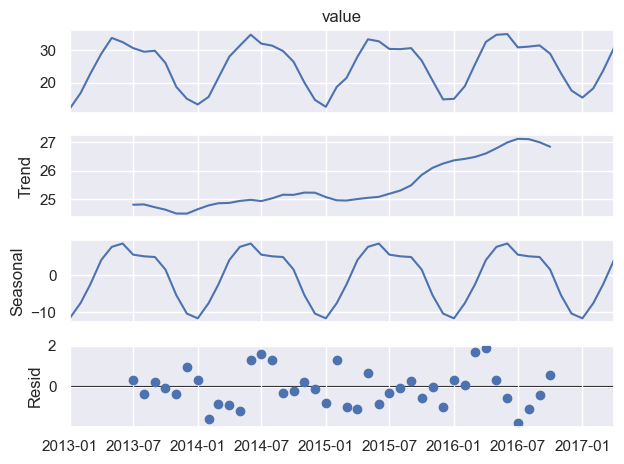

In [4]:
plot_seasonality(df)

# Model Selection

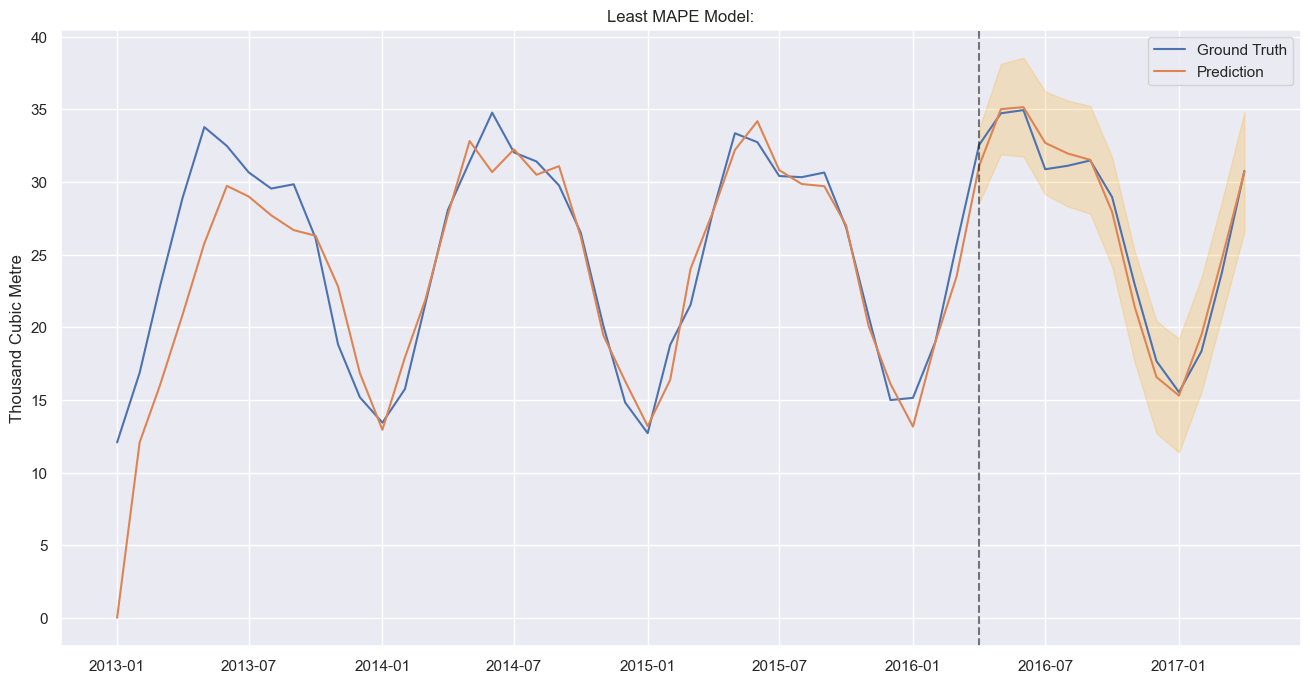

,order,seasonal_order,MAPE,RMSE,MAE
70,"[1, 1, 1]","[1, 0, 1, 12]",0.033042,1.003827,0.821906


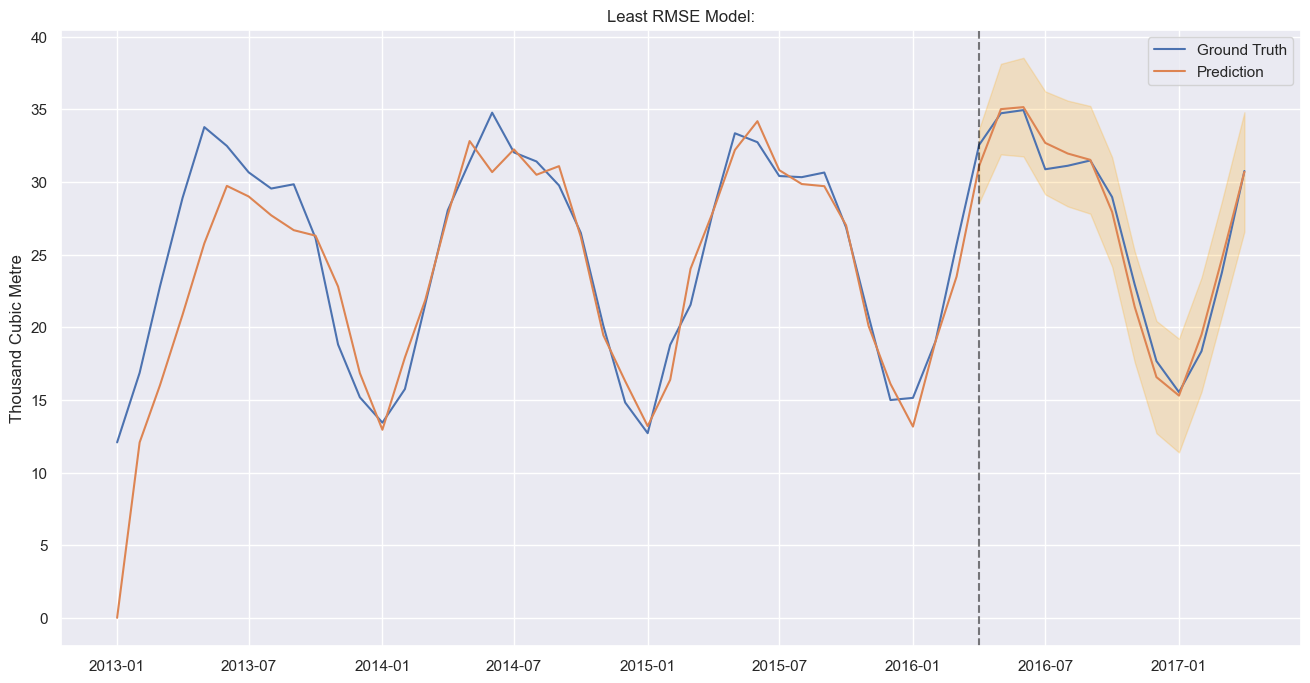

,order,seasonal_order,MAPE,RMSE,MAE
70,"[1, 1, 1]","[1, 0, 1, 12]",0.033042,1.003827,0.821906


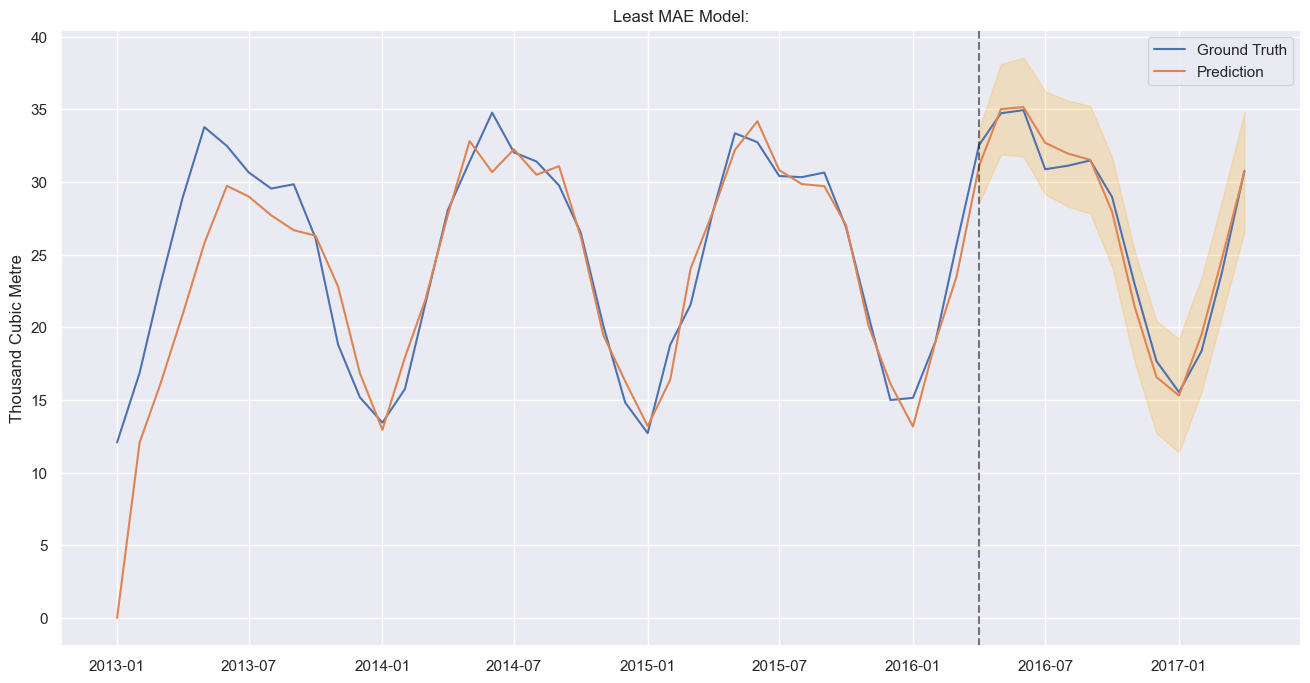

,order,seasonal_order,MAPE,RMSE,MAE
70,"[1, 1, 1]","[1, 0, 1, 12]",0.033042,1.003827,0.821906


In [5]:
def run_model(t):

    # Split the data 
    t_train, t_test = train_test_split(t)

    # Selects the d_D for stationary series
    diff_series = differencing(t_train['value'], [12])
    summary = adf_summary(diff_series)
    summary_passed = summary[summary['p-value'] < 0.05]
    passed_series = diff_series[pd.Index.tolist(summary_passed.index)]
    ps = passed_series.sort_index(axis=1)

    # Selecting the q and p
    q = MA(ps)
    p = AR(ps)
    d_D = d_D_comb(summary_passed)

    # Getting the possible order and seasonal orders
    comb = pdq_grid(p, d_D, q, p, q, 12)
    # t_train = t_train.drop('CostCenter', axis=1)

    # Training different models and storing evaluation metrics
    model_info = SARIMA_grid(endog=t_train.value, test = t_test.value, orders = comb)

    # The 3 best models
    L1 = model_info[model_info.MAPE == model_info.MAPE.min()]
    L2 = model_info[model_info.RMSE == model_info.RMSE.min()]
    L3 = model_info[model_info.MAE == model_info.MAE.min()]
    plot_model(t, t_test, t_train, L1, L2, L3)
run_model(df)